In [1]:
# 2️⃣ Download dataset from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rajyellow46/wine-quality
!unzip -o wine-quality.zip -d wine


Dataset URL: https://www.kaggle.com/datasets/rajyellow46/wine-quality
License(s): other
  0% 0.00/98.0k [00:00<?, ?B/s]
100% 98.0k/98.0k [00:00<00:00, 195MB/s]
Archive:  wine-quality.zip
  inflating: wine/winequalityN.csv   


In [19]:
# 3️⃣ Load Data
import pandas as pd
import numpy as np
df = pd.read_csv("wine/winequalityN.csv")  # white wine data
X = df.drop("quality", axis=1)
y_reg = df["quality"]                # regression target
y_clf = (y_reg >= 7).astype(int)     # binary classification (good / bad)


In [15]:
# Check which column contains non-numeric data
print(X.dtypes)



type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object


In [20]:
# 4️⃣ Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
# Encode 'type' column
X = pd.get_dummies(df.drop("quality", axis=1), drop_first=True)

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Targets
y_reg = df["quality"]
y_clf = (df["quality"] >= 6).astype(int)  # Example: good vs bad wine

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)


scaler = StandardScaler().fit(X_train)


In [25]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SGD": SGDRegressor(max_iter=1000, tol=1e-3, penalty='l2', alpha=0.001, learning_rate='invscaling', eta0=0.01),
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=False)),  # Try degree=1 first
        ("model", model)
    ])
    start = time.time()
    try:
        pipe.fit(X_train, y_reg_train)
        pred = pipe.predict(X_test)
        results.append({
            "model": name,
            "rmse": np.sqrt(mean_squared_error(y_reg_test, pred)),
            "r2": r2_score(y_reg_test, pred),
            "time": time.time() - start
        })
    except Exception as e:
        print(f"❌ Model {name} failed: {e}")

# Show results
pd.DataFrame(results)



,model,rmse,r2,time
0,OLS,0.686601,0.340485,0.016708
1,Ridge,0.686614,0.340461,0.014378
2,Lasso,0.845463,-0.000013,0.012468
3,SGD,0.688402,0.337021,0.015079


In [26]:
# 🧭 Logistic Regression
pipe_clf = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("clf", LogisticRegression(max_iter=1000))
])
pipe_clf.fit(X_train, y_clf_train)
y_pred = pipe_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_clf_test, y_pred))
print("F1 Score:", f1_score(y_clf_test, y_pred))
print(classification_report(y_clf_test, y_pred))


Accuracy: 0.7692307692307693
F1 Score: 0.8245614035087719
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       468
           1       0.80      0.85      0.82       832

    accuracy                           0.77      1300
   macro avg       0.75      0.74      0.74      1300
weighted avg       0.77      0.77      0.77      1300



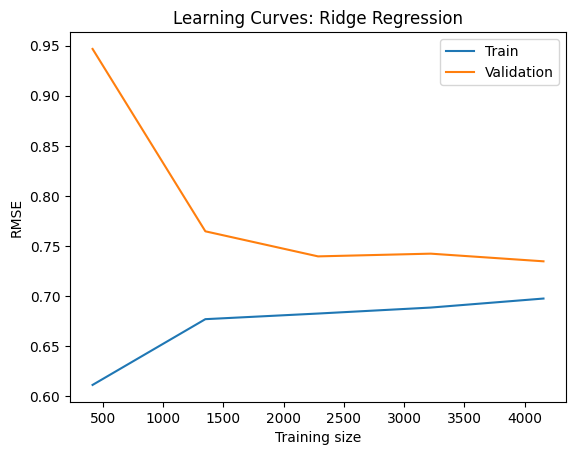

In [27]:
# 📈 Learning Curves
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_reg_train, cv=5,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    train_scores = -train_scores
    val_scores = -val_scores
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
    plt.title(title); plt.xlabel("Training size"); plt.ylabel("RMSE")
    plt.legend()
    plt.show()

plot_learning_curve(Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("model", Ridge())
]), "Learning Curves: Ridge Regression")


In [28]:
# 🔍 Hyperparameter Tuning
param_grid = {
    "model__alpha": [0.1, 0.5, 1.0, 2.0],
}
grid = GridSearchCV(Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2)),
        ("model", Ridge())
    ]), param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X_train, y_reg_train)
print("Best alpha:", grid.best_params_, "RMSE:", np.sqrt(-grid.best_score_))


Best alpha: {'model__alpha': 0.1} RMSE: 0.7357841817040535


Text(0.5, 1.0, 'Top 10 Feature Importance')

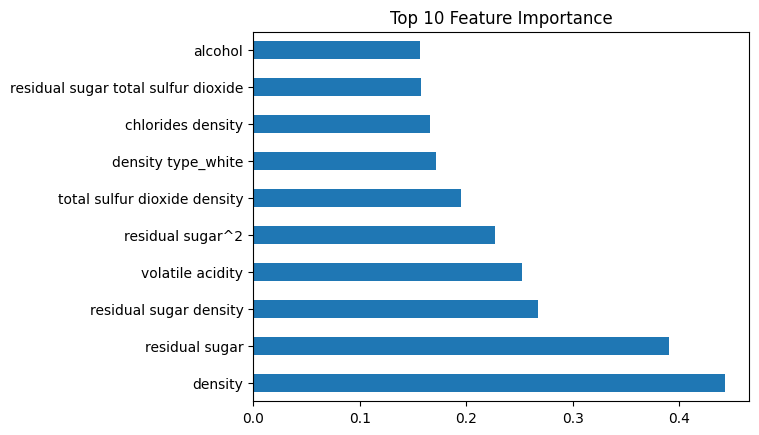

In [29]:
# 📊 Feature Importance for best model
best = grid.best_estimator_
coef = best.named_steps["model"].coef_
features = best.named_steps["poly"].get_feature_names_out(input_features=X.columns)
imp = pd.Series(abs(coef), index=features).sort_values(ascending=False).head(10)
imp.plot(kind="barh"); plt.title("Top 10 Feature Importance")


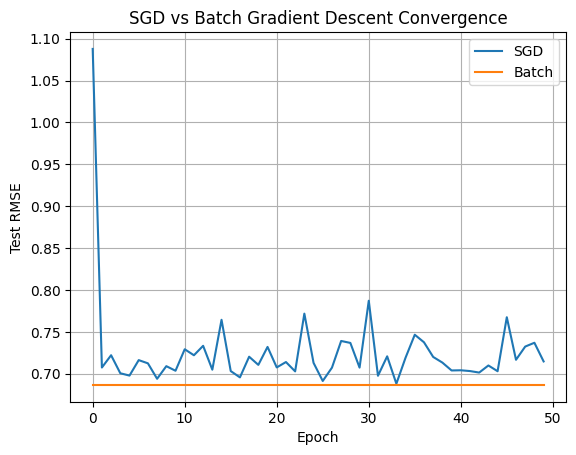

In [31]:
# 🧩 SGD vs Batch Convergence
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error

sgd = SGDRegressor(max_iter=1, tol=None, learning_rate="constant", eta0=0.01, warm_start=True)
batch = LinearRegression()

errors_sgd, errors_batch = [], []
for epoch in range(50):
    sgd.partial_fit(scaler.transform(X_train), y_reg_train)
    pred_sgd = sgd.predict(scaler.transform(X_test))
    errors_sgd.append(np.sqrt(mean_squared_error(y_reg_test, pred_sgd)))

    batch.fit(scaler.transform(X_train), y_reg_train)
    pred_batch = batch.predict(scaler.transform(X_test))
    errors_batch.append(np.sqrt(mean_squared_error(y_reg_test, pred_batch)))

# 📈 Plot convergence
plt.plot(errors_sgd, label="SGD")
plt.plot(errors_batch, label="Batch")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.legend()
plt.title("SGD vs Batch Gradient Descent Convergence")
plt.grid(True)
plt.show()


In [32]:
# 📝 Summary & Report
import json
report = {
    "regression_comparison": pd.DataFrame(results).to_dict(orient="list"),
    "classification": {
        "accuracy": accuracy_score(y_clf_test, y_pred),
        "f1": f1_score(y_clf_test, y_pred),
        "top_errors": {}
    }
}
print(json.dumps(report, indent=2))


{
  "regression_comparison": {
    "model": [
      "OLS",
      "Ridge",
      "Lasso",
      "SGD"
    ],
    "rmse": [
      0.6866012379247409,
      0.6866135569876411,
      0.8454633917827878,
      0.6884018481316845
    ],
    "r2": [
      0.3404845408986843,
      0.34046087451166995,
      -1.2504991929951359e-05,
      0.33702084945932553
    ],
    "time": [
      0.0167081356048584,
      0.01437830924987793,
      0.01246786117553711,
      0.015079259872436523
    ]
  },
  "classification": {
    "accuracy": 0.7692307692307693,
    "f1": 0.8245614035087719,
    "top_errors": {}
  }
}
